# Examen 3 Práctico
## Arantza Gomez Haro Gamboa

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve

In [30]:
def calibracion_multiple(modelos, y, bins):
    for nombre, predicciones in modelos.items():
        df_calibracion = pd.DataFrame({
            'predicciones': predicciones,
            'y': y
        })
        
        df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop') + 1
        grouped = df_calibracion.groupby('bins').mean()
        
        plt.figure()
    
        plt.plot(grouped.predicciones, grouped.y, label=f"{nombre} (Modelo)", marker="o", color="rosybrown")
        plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color="cornflowerblue")
        
        plt.grid()
        plt.legend()
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.title(f"Calibración para {nombre}")

### **Datos:**

In [31]:
df = pd.read_csv('hr_role.csv')
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df = pd.get_dummies(df)

target = 'Attrition'
y = df[target]
X = df.copy()
X = X.drop(target, axis = 1)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Árbol Max Depth 2**

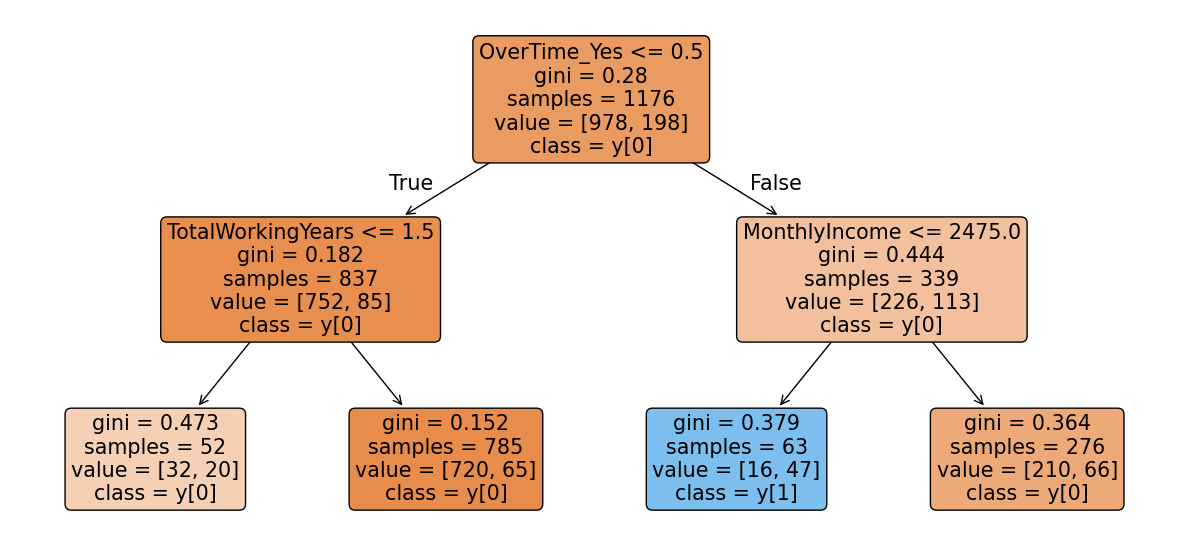

In [33]:
tree = DecisionTreeClassifier(max_depth=2).fit(X_train,y_train)
plt.figure(figsize=(15, 7))
plot_tree(tree, feature_names=X.columns, filled = True, rounded = True, class_names=True)
plt.show()

##### *Análisis:*

- Con el árbol de decisión de max depth 2 se puede ver com el primer split que se hace es según si se trabaja horas extras o no, esto tomando en cuenta un umbral de 0.5. Además, el Gini es de 0.28, lo cual es algo bajo, significando que existe una mayor presencia en una clase en específico. Luego, salen dos ramas, la de la izquierda analiza el Monthly Income. En este caso, se tiene un umbral de 2475, si el ingreso es menor al umbral el Gini es de 0.379, y si es mayor el Gini es de 0.364.
- Por otro lado, en la rama derecha, se analizan los Total Working Years, tomando en cuenta un umbral de 1.5. Si los años trabajados son menores o iguales a 1.5, el Gini es de 0.473, mientras que si son mayores el Gini es de 0.152.

### **Mejor Árbol**

In [34]:
pipeline = Pipeline([
    ('tree', DecisionTreeClassifier())
])

params = {
    'tree__max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13],
    'tree__min_samples_split': [2,3,4,5,6,7,8,9,10],
    'tree__min_samples_leaf': [1,2,3,4,5],
    'tree__max_features': ['log2', 'sqrt', 1, 2, 3, 4, 5]
}

grid_tree = GridSearchCV(estimator = pipeline, cv=5, n_jobs=-1, scoring = 'roc_auc', param_grid = params)
grid_tree.fit(X_train, y_train)

c:\Users\arant\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tree', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'tree__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                             12, 13],
                         'tree__max_features': ['log2', 'sqrt', 1, 2, 3, 4, 5],
                         'tree__min_samples_leaf': [1, 2, 3, 4, 5],
                         'tree__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9,
                                                     10]},
             scoring='roc_auc')

In [35]:
grid_tree.best_params_

{'tree__max_depth': 5,
 'tree__max_features': 5,
 'tree__min_samples_leaf': 5,
 'tree__min_samples_split': 8}

In [36]:
best_model = grid_tree.best_estimator_.named_steps['tree']
predicciones = best_model.predict_proba(X_test)[:,1]
auc_dtc = roc_auc_score(y_score=predicciones, y_true=y_test)
auc_dtc

0.665560583207642

##### *Feature Importance:*

In [37]:
importancias = pd.DataFrame({
    'variables': X.columns,
    'importancia': best_model.feature_importances_
})

importancias.sort_values('importancia', ascending = False, inplace = True)
importancias.head(10)

,variables,importancia
8,MonthlyIncome,0.297204
51,OverTime_No,0.266458
16,TotalWorkingYears,0.098899
10,NumCompaniesWorked,0.063489
2,DistanceFromHome,0.063439
47,MaritalStatus_Divorced,0.036324
25,BusinessTravel_Travel_Frequently,0.032891
4,EnvironmentSatisfaction,0.031707
49,MaritalStatus_Single,0.030445
19,YearsAtCompany,0.026951


##### *Análisis:*

- Tras obtener los resultados, se puede concluir que el mejor árbol que se obtuvo tiene los siguientes parámetros:
    - 5 de max depth
    - 5 max features
    - Min samples leaf de 5
    - Min samples split de 8
- Dicho esto, se obtuvo un AUC de 0.6655. Aunque este porcentaje no es malo, definitivamente existe área para mejorar en cuestión de la precisión del modelo. 

- Por otro lado, la variable con mayor importancia fue la de **YearsWithCurrManager**, seguida por la variable de **OverTime_No**, y luego **Monthly Income**, con importancias de 0.2972, 0.2664 y 0.098 (en ese orden)

### **Modelos:**

#### Random Forest

In [38]:
len(X_train.keys())

53

In [39]:
pipeline = Pipeline([
    ('rf', RandomForestClassifier(n_estimators=300, n_jobs = -1))
])

params = {
    'rf__max_depth': [20, 25, 20, 35, 40],
    'rf__max_features': ['log2', 'sqrt', 35, 40, 45, 53]
}

rf_grid = GridSearchCV(estimator=pipeline, n_jobs = -1, cv=5, scoring='roc_auc', param_grid=params)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(n_estimators=300,
                                                               n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [20, 25, 20, 35, 40],
                         'rf__max_features': ['log2', 'sqrt', 35, 40, 45, 53]},
             scoring='roc_auc')

In [40]:
rf_grid.best_params_

{'rf__max_depth': 40, 'rf__max_features': 'log2'}

In [41]:
best_model =rf_grid.best_estimator_.named_steps['rf']
predicciones_rf = best_model.predict_proba(X_test)[:,1]
auc_rf = roc_auc_score(y_score=predicciones_rf, y_true=y_test)

##### *Feature Importance:*

In [42]:
importancias = pd.DataFrame({
    'variables': X.columns,
    'importancia': best_model.feature_importances_
})

importancias.sort_values('importancia', ascending = False, inplace = True)
importancias.head(10)

,variables,importancia
8,MonthlyIncome,0.069866
0,Age,0.054707
16,TotalWorkingYears,0.047149
1,DailyRate,0.046853
9,MonthlyRate,0.046002
5,HourlyRate,0.042780
19,YearsAtCompany,0.041935
51,OverTime_No,0.039288
2,DistanceFromHome,0.038906
52,OverTime_Yes,0.033985


##### *Análisis:*

- Tras realizar el modelo de *Random Forest*, la variable con mayor importancia fue la de **Monthly Income**, seguida por la variable de **Age**, y luego **Total Working Years**, con importancias de 0.0698, 0.0547 y 0.0471 (en ese orden). En este caso, se puede ver como las variables de Monthly Income y Total Woring Years siguen siendo de las que tienen mayor importancia, y se agrega la variable de Age.

#### XGBoost:

In [43]:
model = XGBClassifier(
    n_estimators = 100_000,
    max_depth = 5,
    learning_rate = 0.1,
    reg_lambda = 0.1,
    subsample = 0.5,
    col_sample_by_tree = 0.8,
    tree_method = 'hist',
    early_stopping_rounds = 40
)

model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100)

[0]	validation_0-logloss:0.42412	validation_1-logloss:0.38659


c:\Users\arant\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:06:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "col_sample_by_tree" } are not used.

  self.starting_round = model.num_boosted_rounds()


[77]	validation_0-logloss:0.09290	validation_1-logloss:0.34479


XGBClassifier(base_score=None, booster=None, callbacks=None,
              col_sample_by_tree=0.8, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=40, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100000, n_jobs=None, ...)

In [44]:
predicciones_xg = model.predict_proba(X_test)[:,1]
auc_xg = roc_auc_score(y_score=predicciones_xg, y_true=y_test)

##### *Feature Importance:*

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

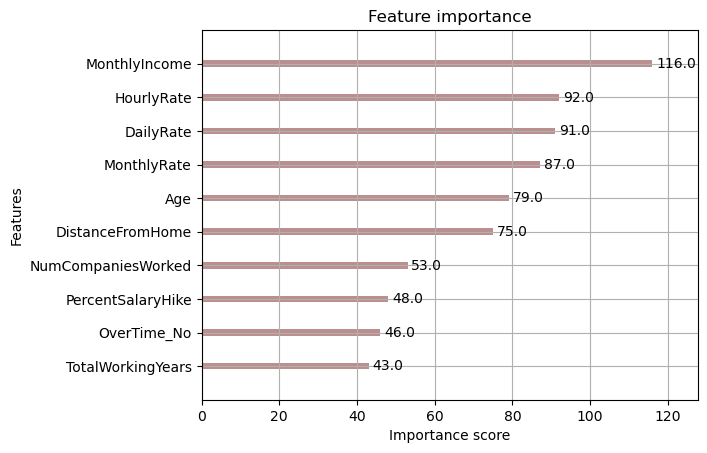

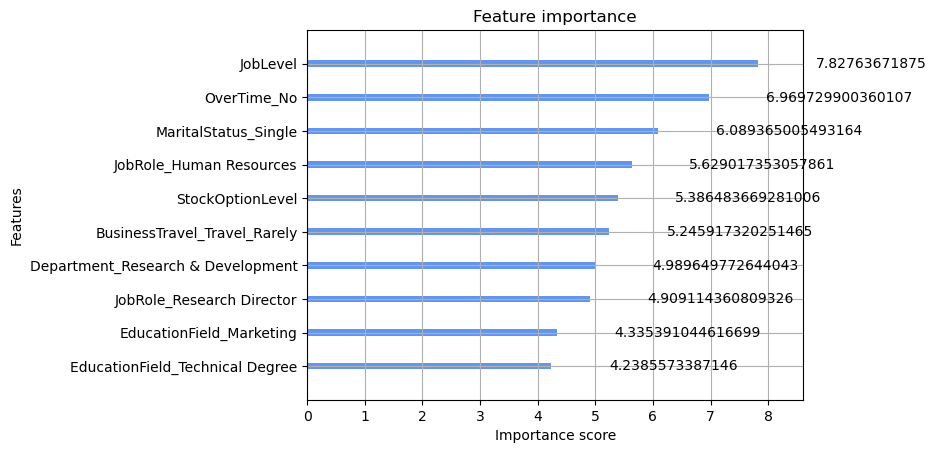

In [45]:
plot_importance(model, max_num_features=10, importance_type="weight", color = 'rosybrown')
plot_importance(model, max_num_features=10, importance_type="gain", color = 'cornflowerblue')

##### *Análisis:*

- En el modelo de *XGBoost*, se realizó la feature importance de dos maneras, que son weight y gain. En cuestión del weight, se tiene que las variables que se utilizan más en el modelo son **Monthly Income**, **Hourly Rate** y **Daily Rate**. Con esto se puede ver como se vuelve a ver la variable de Monthly Income. 

- Por otro lado, en cuestión del gain, se tiene que las variables que en promedio causan una mayor reducción en la función de pérdida dado su uso son **Job Level**, **OverTime No** y **Maritial Status Single**. Con esto, podemos ver que surgieron variables que no se habían tomado en cuenta hasta este modelo. 

#### LightGBM:

In [46]:
model = LGBMClassifier(
    n_estimators=100_000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1
)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='rmse',
          callbacks=[early_stopping(40),
                     log_evaluation(100)])

Training until validation scores don't improve for 40 rounds
[100]	training's rmse: 0.161325	training's binary_logloss: 0.117939	valid_1's rmse: 0.306725	valid_1's binary_logloss: 0.322622
Early stopping, best iteration is:
[77]	training's rmse: 0.189117	training's binary_logloss: 0.147445	valid_1's rmse: 0.307034	valid_1's binary_logloss: 0.322332


LGBMClassifier(feature_fraction=0.8, lambda_l2=0.1, max_depth=6,
               n_estimators=100000, num_leaves=10, subsample=0.8, verbosity=-1)

In [47]:
predicciones_light = model.predict_proba(X_test)[:,1]
auc_light = roc_auc_score(y_score=predicciones_light, y_true=y_test)

##### *Feature Importance:*

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

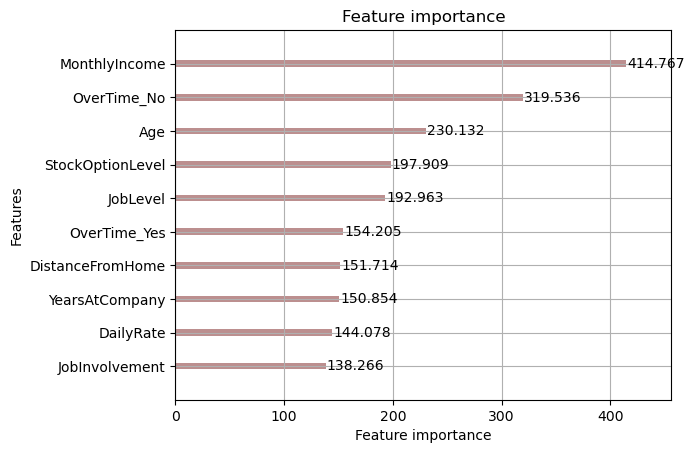

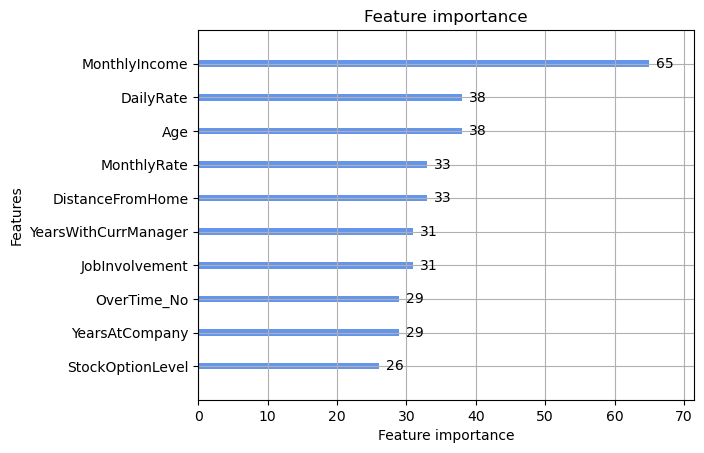

In [48]:
lgb.plot_importance(model, max_num_features = 10, importance_type='gain', color = 'rosybrown')
lgb.plot_importance(model, max_num_features = 10, importance_type='split', color = 'cornflowerblue')

##### *Análisis:*

- En el modelo de *LightGBM*, se realizó la feature importance de dos maneras, que son gain y split. En cuestión del split, se tiene que las variables que se utilizan más en el modelo son **Monthly Income**, **Daily Rate** y **Age**. Con esto se puede ver como se vuelven a ver las tres variables en este análisis, resalntando su importancia e influencia en el dataset.

- Por otro lado, en cuestión del gain, se tiene que las variables que en promedio causan una mayor reducción en la función de pérdida dado su uso son **Monthly Income**, **OverTime No** y **Age**. Con esto, podemos ver como las variables Monthly Income y Age se repiten dentro del análisis de este mismo modelo, y Over Time No vuelve a aparecer como en modelos anteriores.

#### CatBoost

In [49]:
cat_cols = [col for col in X_train.columns if X_train[col].nunique() < 50]

for col in cat_cols:
    X_train[col] = X_train[col].astype(str).fillna('missing')
    X_test[col] = X_test[col].astype(str).fillna('missing')

In [50]:
model = CatBoostClassifier(
    iterations=100_000,         
    depth=5,                   
    learning_rate=0.1,
    subsample=0.5,             
    rsm=0.8,                  
    eval_metric='AUC',
    early_stopping_rounds=40,
    verbose = 100)           

model.fit(
    X_train, y_train,
    cat_features=cat_cols,
    eval_set=[(X_test, y_test)],
)

predicciones_catboost = model.predict_proba(X_test)[:,1]
auc_cat = roc_auc_score(y_score=predicciones_catboost, y_true=y_test)

0:	test: 0.5547009	best: 0.5547009 (0)	total: 27.2ms	remaining: 45m 17s
100:	test: 0.7710407	best: 0.7710407 (100)	total: 5.4s	remaining: 1h 28m 59s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.7733534439
bestIteration = 104

Shrink model to first 105 iterations.


In [51]:
df_importances = pd.DataFrame({
    'feature': model.feature_names_,
    'importance': model.feature_importances_
})

#.sort_values(by='importance', ascending=False)
importancias.sort_values('importancia', ascending = False, inplace = True)
importancias.head(10)

,variables,importancia
8,MonthlyIncome,0.069866
0,Age,0.054707
16,TotalWorkingYears,0.047149
1,DailyRate,0.046853
9,MonthlyRate,0.046002
5,HourlyRate,0.042780
19,YearsAtCompany,0.041935
51,OverTime_No,0.039288
2,DistanceFromHome,0.038906
52,OverTime_Yes,0.033985


##### *Análisis:*

- En el modelo de CatBoost, se realizó el feature importance y se obtuvo que la variable con mayor importanciaes **Monthly Income**, seguida por **Age** y **Total Working Years**, con valores de 0.0698, 0.0547 y 0.0471 (en ese orden). Nuevamente, se puede ver que Monthly Income destaca en este modelo, al igual que Age y Total Working Years que también han aparecido en múltiples modelos. Con esto, se puede concluir la alta importancia y dependencia de la variable de Monthly Income en la mayoría de los modelos presentados.

### **Gráficas de Calibración:**

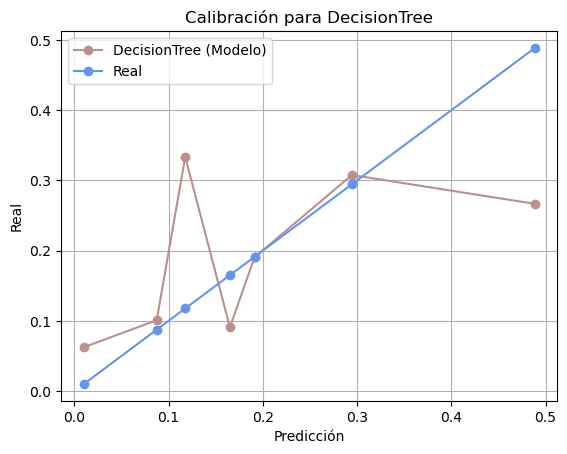

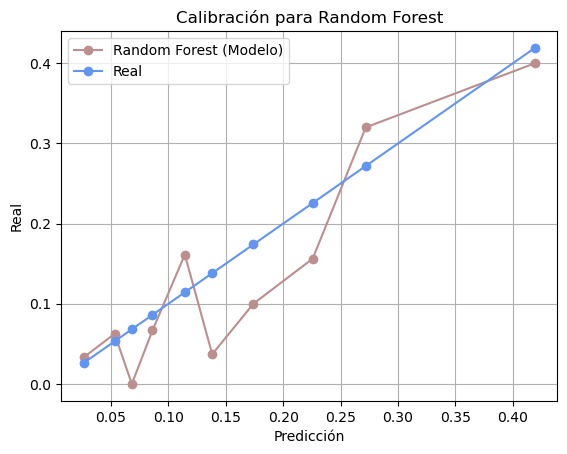

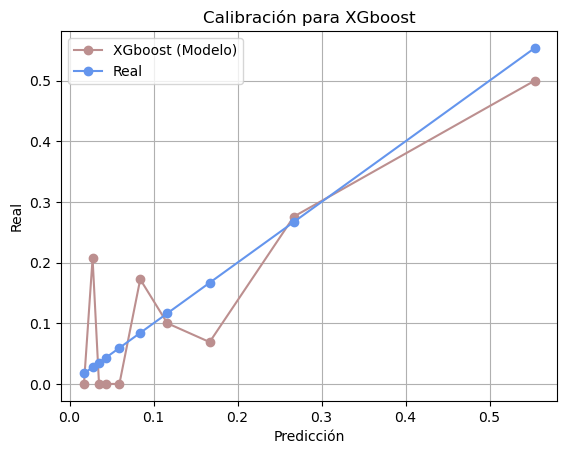

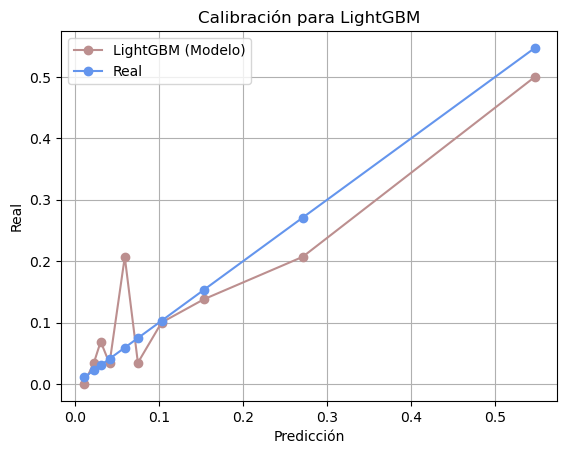

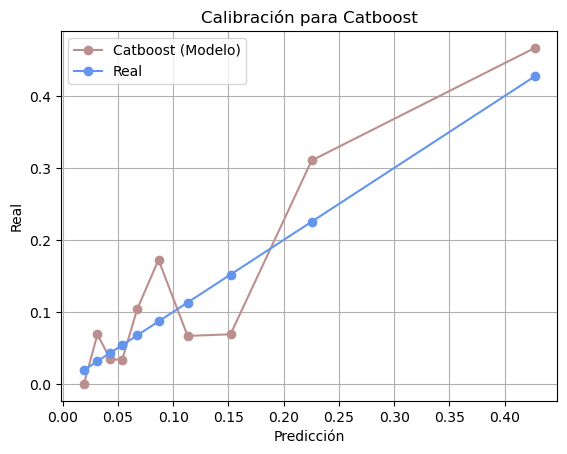

In [52]:
modelos = {
    'DecisionTree': predicciones,
    'Random Forest': predicciones_rf,
    'XGboost': predicciones_xg,
    'LightGBM': predicciones_light,
    'Catboost': predicciones_catboost,
}

calibracion_multiple(modelos, y_test, bins=10)

### **Histogramas:**

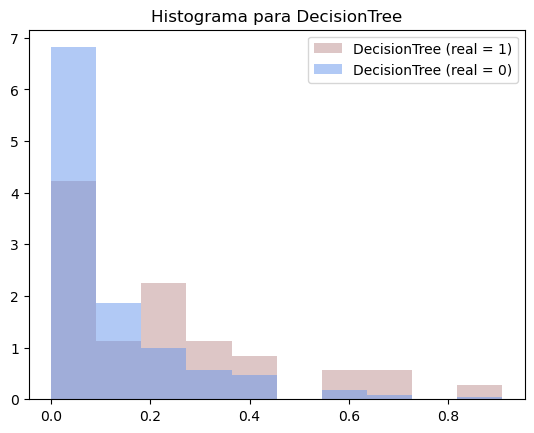

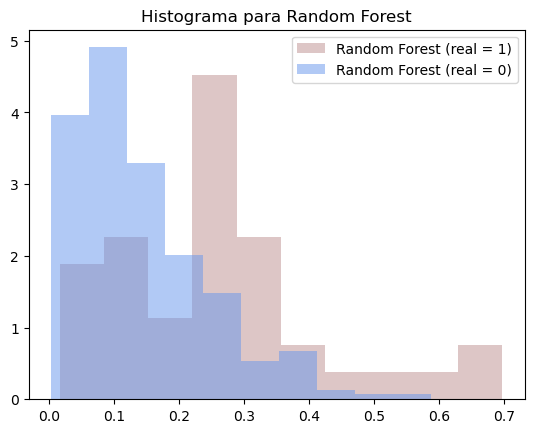

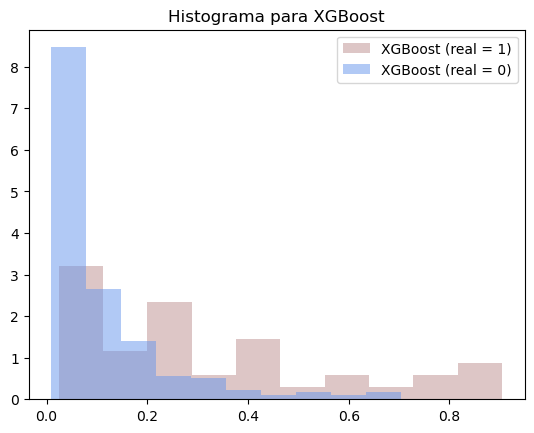

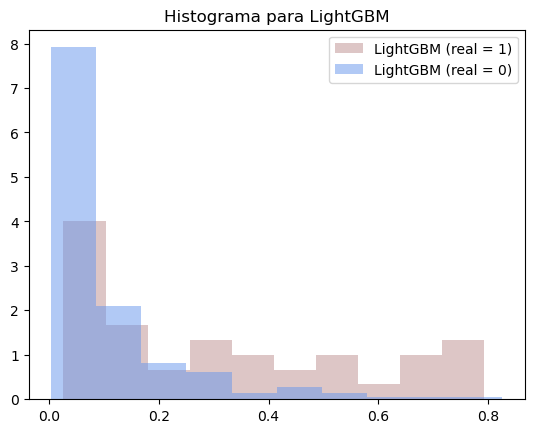

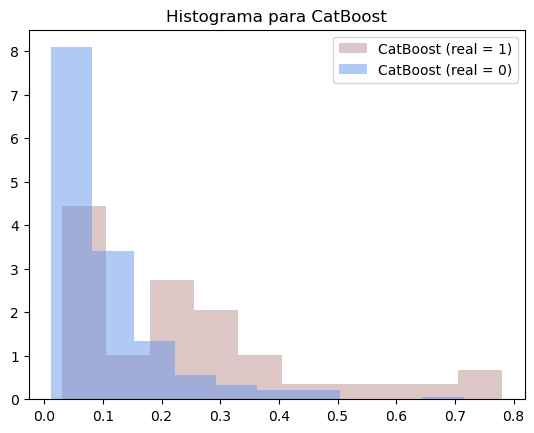

In [53]:
histogramas = pd.DataFrame({
    'real': y_test,
    'DecisionTree': predicciones,
    'Random Forest': predicciones_rf,
    'XGBoost': predicciones_xg,
    'LightGBM': predicciones_light,
    'CatBoost': predicciones_catboost,
})

real1 = histogramas[histogramas['real'] == 1]
real0 = histogramas[histogramas['real'] == 0]

modelos = ['DecisionTree', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']

for modelo in modelos:
    plt.hist(real1[modelo], density=True, alpha=0.5, bins=10, color='rosybrown', label=f'{modelo} (real = 1)')
    plt.hist(real0[modelo], density=True, alpha=0.5, bins=10, color='cornflowerblue', label=f'{modelo} (real = 0)')
    plt.title(f'Histograma para {modelo}')
    plt.legend()
    plt.show()

### **Curva ROC:**

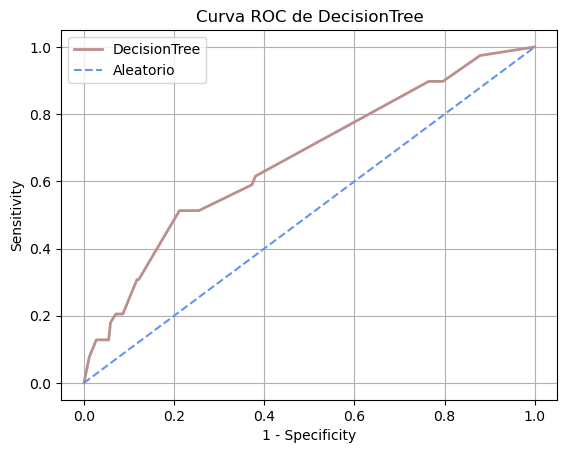

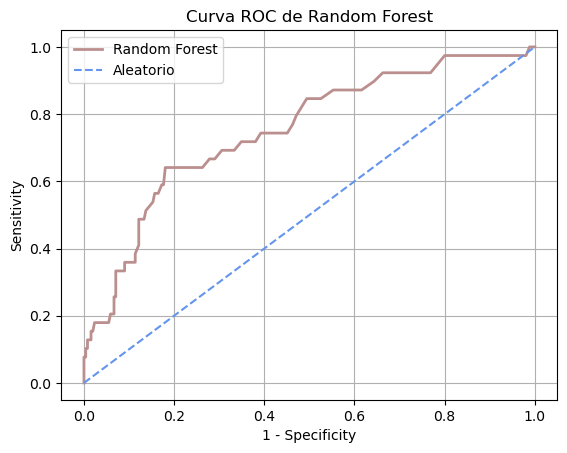

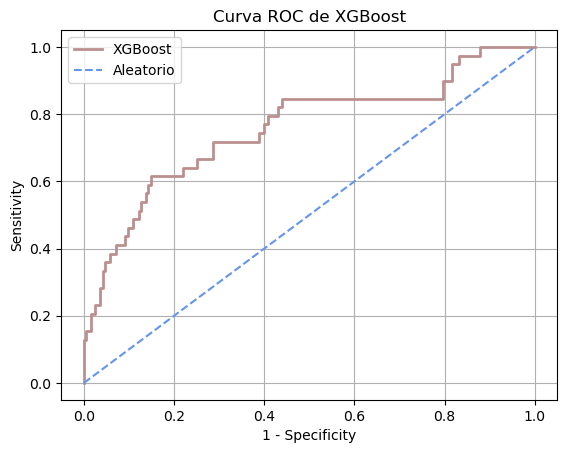

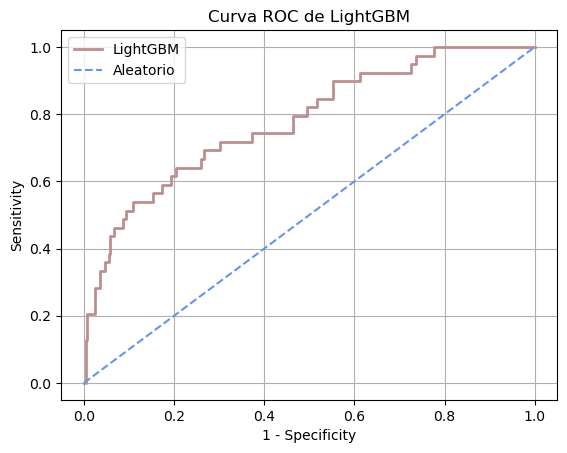

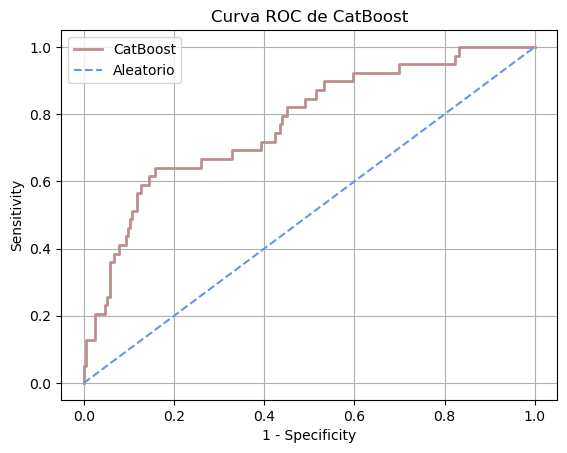

In [54]:
resultados = [predicciones, predicciones_rf, predicciones_xg, predicciones_light, predicciones_catboost]

for i, modelo in enumerate(modelos):
    predicciones = resultados[i]
    fpr, tpr, _ = roc_curve(y_true=y_test, y_score=predicciones) 
    plt.plot(fpr, tpr, label=f'{modelo}', color='rosybrown', lw=2)
    plt.plot([0, 1], [0, 1], color='cornflowerblue', linestyle='--', lw=1.5, label='Aleatorio')
    plt.title(f'Curva ROC de {modelo}')
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.legend()
    plt.grid(True)
    plt.show()

### **AUC:**

In [55]:
tabla = pd.DataFrame({
    'DecisionTree': auc_dtc,
    'Random Forest': auc_rf,
    'XGBoost': auc_xg,
    'LightGBM': auc_light,
    'CatBoost': auc_cat
}, index=['AUC'])
tabla

,DecisionTree,Random Forest,XGBoost,LightGBM,CatBoost
AUC,0.665561,0.752388,0.758773,0.78009,0.773353


##### *Conclusiones:*

- En conclusión, el mejor modelo que se obtuvo tras realizarlos fue el de **LightGBM**, con un AUC Score de 0.78009. Esto nos indica que este modelo cuenta con una buena capacidad de discriminación entre clases, teniendo una precisión de aproximidamente 78%. En cuestión de las gráficas de calibración, se puede ver como el modelo de LightGBM es el que mejor se ajuste, sin embargo, aun cuenta con espacio para mejorar. Por otro lado, la Curva ROC y el histograma de este modelo también reslantan, demostrando que LightGBM fue el mejor modelo. 

- Es importante recalcar que en el feature importance, con split, las variables que salieron más arriba fueron Monthly Income, Daily Rate y Age, mientras que con gain fueron Monthly Income, OverTime No y Age. Esto nos demuestra que Monthly Income es una de las variables más relevantes en el dataset, sin importar el criterio que se utilice (gain o split). Además, la variable de Age también es un factor importante al momento de analizar el target establecido. 

- Dicho todo esto, es evidente que el modelo de LightGBM fue el mejor, sin embargo, es importante mencionar que los modelos de CatBoost, Random Forest y XGBoost obtuvieron valores de AUC Score bastante cercanos. El único modelo con una precisión menor al 75% fue en el que se usó Decision Tree, resaltando la importancia de utilizar modelos un poco más complejos para obtener mejores resultados. 
